Saving data.csv to data.csv
Silhouette Score: 0.4133


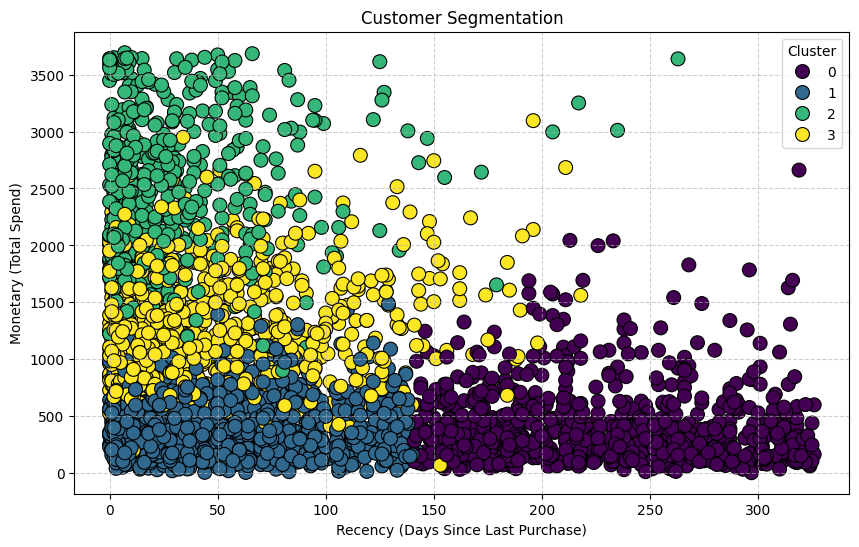

Cluster Profiles:
         Recency  Frequency  Monetary
Cluster                              
0         229.85       1.48    402.92
1          50.89       1.62    425.73
2          31.24       6.96   2484.09
3          45.06       3.94   1258.63


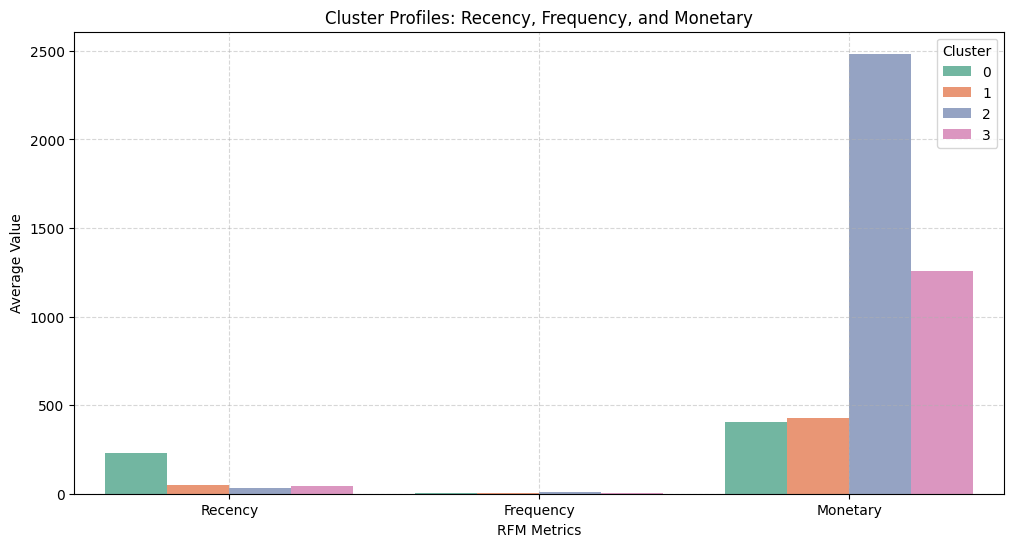

Recommended Products for Customer 17850: ['85123A', '82494L', '82482', '82486', '22170']
Clustered RFM data exported successfully!


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from google.colab import files

# Upload File
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Load Data
df = pd.read_csv(file_name, encoding="ISO-8859-1")

# Data Cleaning
df.dropna(subset=['CustomerID'], inplace=True)
df['CustomerID'] = df['CustomerID'].astype(int)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# RFM Analysis
latest_date = df['InvoiceDate'].max()
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Outlier Removal
Q1 = rfm.quantile(0.25)
Q3 = rfm.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[~((rfm < (Q1 - 1.5 * IQR)) | (rfm > (Q3 + 1.5 * IQR))).any(axis=1)]

# Normalize
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Silhouette Score
score = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f"Silhouette Score: {score:.4f}")

# Cluster Visualization (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis', s=100, edgecolor='black')
plt.title("Customer Segmentation")
plt.xlabel("Recency (Days Since Last Purchase)")
plt.ylabel("Monetary (Total Spend)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Cluster")
plt.show()

# Cluster Profiling
cluster_profile = rfm.groupby('Cluster').mean().round(2)
print("Cluster Profiles:")
print(cluster_profile)

# Visualize Cluster Profiles as Colored Bar Chart
cluster_profile_reset = cluster_profile.reset_index()
cluster_profile_melted = cluster_profile_reset.melt(id_vars='Cluster', var_name='Metric', value_name='Value')

plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_profile_melted, x='Metric', y='Value', hue='Cluster', palette='Set2')
plt.title('Cluster Profiles: Recency, Frequency, and Monetary')
plt.xlabel('RFM Metrics')
plt.ylabel('Average Value')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Cluster')
plt.show()

# Product Recommendation System
product_matrix = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', fill_value=0)
neigh = NearestNeighbors(n_neighbors=5, metric='cosine')
neigh.fit(product_matrix.values)  # fit using the matrix only (no feature names)

def recommend_products(customer_id, n_recommendations=5):
    if customer_id not in product_matrix.index:
        return "Customer ID not found."
    customer_vector = product_matrix.loc[customer_id].values.reshape(1, -1)  # pass as numpy array
    distances, indices = neigh.kneighbors(customer_vector)
    similar_customers = product_matrix.index[indices[0][1:]]
    recommended_products = (
        df[df['CustomerID'].isin(similar_customers)]['StockCode']
        .value_counts()
        .head(n_recommendations)
        .index
        .tolist()
    )
    return recommended_products

# Example Usage
customer_id = 17850
print(f"Recommended Products for Customer {customer_id}:", recommend_products(customer_id))

# Export clustered RFM data
rfm.to_csv("Clustered_Customers.csv")
print("Clustered RFM data exported successfully!")
